In [16]:
import pandas as pd
import numpy as np

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterBaseline import ForecasterEquivalentDate
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import bayesian_search_forecaster
from sklearn.metrics import mean_pinball_loss

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
import seaborn as sns

from skforecast.plot import plot_residuals

pio.renderers.default = 'notebook' 
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)
plt.style.use('seaborn-v0_8-darkgrid')

In [3]:
# Read data
# ==============================================================================
data_dir = 'Data/spain/four years'
# data_dir = 'Data/spain/one year'

df = pd.read_csv(data_dir + '/spain_clean.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index(keys = 'datetime', inplace=True)
df = df.asfreq('60min')
df.head()

,wave_height,period
datetime,,
2020-06-18 00:00:00,0.78,4.92
2020-06-18 01:00:00,0.76,5.06
2020-06-18 02:00:00,0.74,5.16
2020-06-18 03:00:00,0.73,5.22
2020-06-18 04:00:00,0.73,5.28


In [4]:
# Train-test split
# ==============================================================================
one_month = (-1)*30*24 # One month
two_months = (-1)*60*24 # Two months

end_train = two_months + two_months
end_val = two_months

df_train = df.iloc[:end_train].copy()
df_val = df.iloc[end_train:end_val].copy()
df_test = df.iloc[end_val:].copy()

print(f"Train dates      : {df_train.index.min()} --- {df_train.index.max()}  (n={len(df_train)})")
print(f"Validation dates : {df_val.index.min()} --- {df_val.index.max()}  (n={len(df_val)})")
print(f"Test dates       : {df_test.index.min()} --- {df_test.index.max()}  (n={len(df_test)})")

Train dates      : 2020-06-18 00:00:00 --- 2024-02-19 23:00:00  (n=32208)
Validation dates : 2024-02-20 00:00:00 --- 2024-04-19 23:00:00  (n=1440)
Test dates       : 2024-04-20 00:00:00 --- 2024-06-18 23:00:00  (n=1440)


## Baseline model

In [4]:
# Create baseline: value of the same hour of the previous day
# ==============================================================================
forecaster = ForecasterEquivalentDate(
                 offset    = pd.DateOffset(hours=1),
                 n_offsets = 1
             )

# Train forecaster
# ==============================================================================
forecaster.fit(y=df.iloc[:end_val]['wave_height'])
forecaster

ForecasterEquivalentDate 
Offset: <DateOffset: hours=1> 
Number of offsets: 1 
Aggregation function: mean 
Window size: 1 
Training range: [Timestamp('2020-06-18 00:00:00'), Timestamp('2024-04-19 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: 60T 
Creation date: 2024-07-08 12:49:17 
Last fit date: 2024-07-08 12:49:17 
Skforecast version: 0.12.1 
Python version: 3.11.9 
Forecaster id: None 

In [5]:
# Backtesting
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = df['wave_height'],
                          steps              = 24,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(df.iloc[:end_val]),
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = False,
                          show_progress      = True
                      )

print(f"Backtest error (MAE): {metric}")

  0%|          | 0/60 [00:00<?, ?it/s]

Backtest error (MAE): 0.19531944444444443


## Recursive multi-step forecasting

A recursive autoregressive model `ForecasterAutoreg` is trained using a gradient boosting regressor `XGBRegressor` as the base regressor. A time window of 24 hours (24 lags) is used to predict the next hour's demand. This means that the demand values of the previous 24 hours are used as predictors. The hyperparameters of the underlying regressor are left at their default values.

We add a custom weight function to ignore missing values during training. 



In [6]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = XGBRegressor(random_state = 42),
                lags = 24)

# Train forecaster
# ==============================================================================
forecaster.fit(y=df.iloc[:end_val]['wave_height'])
forecaster

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Differentiation order: None 
Exogenous i

In [7]:
# Backtesting
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = df['wave_height'],
                          steps              = 24,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(df.iloc[:end_val]),
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = True,
                          show_progress      = True
                      )

# Backtesting error
# ==============================================================================
print(f'Backtest error (MAE): {metric}')

Information of backtesting process
----------------------------------
Number of observations used for initial training: 33648
Number of observations used for backtesting: 1440
    Number of folds: 60
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2020-06-18 00:00:00 -- 2024-04-19 23:00:00  (n=33648)
    Validation: 2024-04-20 00:00:00 -- 2024-04-20 23:00:00  (n=24)
Fold: 1
    Training:   2020-06-18 00:00:00 -- 2024-04-19 23:00:00  (n=33648)
    Validation: 2024-04-21 00:00:00 -- 2024-04-21 23:00:00  (n=24)
Fold: 2
    Training:   2020-06-18 00:00:00 -- 2024-04-19 23:00:00  (n=33648)
    Validation: 2024-04-22 00:00:00 -- 2024-04-22 23:00:00  (n=24)
Fold: 3
    Training:   2020-06-18 00:00:00 -- 2024-04-19 23:00:00  (n=33648)
    Validation: 2024-04-23 00:00:00 -- 2024-04-23 23:00:00  (n=24)
Fold: 4
    Training:   2020-06-18 00:00:00 -- 2024-04-19 23:00:00  (n=33648)
    Validation: 2024-04-2

  0%|          | 0/60 [00:00<?, ?it/s]

Backtest error (MAE): 0.19748327859739462


In [8]:
# Plot predictions vs real value
# ======================================================================================
fig = go.Figure()
trace1 = go.Scatter(x=df_test.index, y=df_test['wave_height'], name="actual", mode="lines")
trace2 = go.Scatter(x=predictions.index, y=predictions['pred'], name="prediction", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Actual value vs predicted in test data",
    xaxis_title="Date time",
    yaxis_title="Wave height (meters)",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="left",
        x=0.001
    )
)
fig.show()

### Hyperparameter tuning

The trained `ForecasterAutoreg` object used the first 24 lags and a `XGBRegressor` model with the default hyperparameters. However, there is no reason why these values are the most appropriate. To find the best hyperparameters, a Bayesian Search is performed using the `bayesian_search_forecaster()` function. The search is carried out using the same backtesting process as before, but each time, the model is trained with different combinations of hyperparameters and lags. It is important to note that the hiperparameter search must be done using the validation set, so the test data is never used.

In [9]:
# Hyperparameters search
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = XGBRegressor(random_state=42),
                 lags      = 24, # This value will be replaced in the grid search
             )

# Lags used as predictors
# lags_grid = [24, 48, [1, 2, 3, 24]]

# Regressor hyperparameters search space
def search_space(trial):
    search_space  = {
        'n_estimators'  : trial.suggest_int('n_estimators', 600, 1200, step=50),
        'max_depth'     : trial.suggest_int('max_depth', 3, 12, step=1),
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.5),
        'reg_alpha'     : trial.suggest_float('reg_alpha', 0, 1, step=0.1),
        'reg_lambda'    : trial.suggest_float('reg_lambda', 0, 1, step=0.1),
        'lags'          : trial.suggest_categorical('lags', [24, 36, 48])
    } 
    return search_space

results_search, frozen_trial = bayesian_search_forecaster(
                                   forecaster         = forecaster,
                                   y                  = df.iloc[:end_val]['wave_height'],
                                   steps              = 24,
                                   metric             = 'mean_absolute_error',
                                   search_space       = search_space,
                                #    lags_grid          = lags_grid,
                                   initial_train_size = len(df[:end_train]),
                                   refit              = False,
                                   n_trials           = 200, # Increase for more exhaustive search
                                   random_state       = 42,
                                   return_best        = True,
                                   n_jobs             = 'auto',
                                   verbose            = False,
                                   show_progress      = True
                               )

  0%|          | 0/200 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'n_estimators': 750, 'max_depth': 4, 'learning_rate': 0.010438386226038208, 'reg_alpha': 0.0, 'reg_lambda': 0.6000000000000001}
  Backtesting metric: 0.30905682644579147



In [32]:
best_params = results_search['params'].iloc[0]
best_params

{'n_estimators': 750,
 'max_depth': 4,
 'learning_rate': 0.010438386226038208,
 'reg_alpha': 0.0,
 'reg_lambda': 0.6000000000000001}

In [10]:
# Backtest final model on test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = df['wave_height'],
                          steps              = 24,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(df[:end_val]),
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = False, # Change to True to see detailed information
                          show_progress      = True
                      )

print(f"Backtest error: {metric:.2f}")

  0%|          | 0/60 [00:00<?, ?it/s]

Backtest error: 0.18


In [11]:
# Plot predictions vs real value
# ======================================================================================
fig = go.Figure()
trace1 = go.Scatter(x=df_test.index, y=df_test['wave_height'], name="actual", mode="lines")
trace2 = go.Scatter(x=predictions.index, y=predictions['pred'], name="prediction", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Actual value vs predicted in test data",
    xaxis_title="Date time",
    yaxis_title="Wave height (meters)",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="left",
        x=0.001
    )
)
fig.show()

Backtest error was: 0.18

## Probabilistic forecasting

### Helper functions

In [25]:
# Function to plot predicted intervals
# ======================================================================================
def plot_predicted_intervals(
    predictions: pd.DataFrame,
    y_true: pd.DataFrame,
    target_variable: str,
    initial_x_zoom: list=None,
    title: str=None,
    xaxis_title: str=None,
    yaxis_title: str=None,
):
    """
    Plot predicted intervals vs real values

    Parameters
    ----------
    predictions : pandas DataFrame
        Predicted values and intervals.
    y_true : pandas DataFrame
        Real values of target variable.
    target_variable : str
        Name of target variable.
    initial_x_zoom : list, default `None`
        Initial zoom of x-axis, by default None.
    title : str, default `None`
        Title of the plot, by default None.
    xaxis_title : str, default `None`
        Title of x-axis, by default None.
    yaxis_title : str, default `None`
        Title of y-axis, by default None.
    
    """

    fig = go.Figure([
        go.Scatter(name='Prediction', x=predictions.index, y=predictions['pred'], mode='lines'),
        go.Scatter(name='Real value', x=y_true.index, y=y_true[target_variable], mode='lines'),
        go.Scatter(
            name='Upper Bound', x=predictions.index, y=predictions['upper_bound'],
            mode='lines', marker=dict(color="#444"), line=dict(width=0), showlegend=False
        ),
        go.Scatter(
            name='Lower Bound', x=predictions.index, y=predictions['lower_bound'],
            marker=dict(color="#444"), line=dict(width=0), mode='lines',
            fillcolor='rgba(68, 68, 68, 0.3)', fill='tonexty', showlegend=False
        )
    ])
    fig.update_layout(
        title=title,
        xaxis_title=xaxis_title,
        yaxis_title=yaxis_title,
        width=900,
        height=400,
        margin=dict(l=20, r=20, t=35, b=20),
        hovermode="x",
        xaxis=dict(range=initial_x_zoom),
        legend=dict(
            orientation="h",
            yanchor="top",
            y=1.1,
            xanchor="left",
            x=0.001
        )
    )
    fig.show()


def empirical_coverage(y, lower_bound, upper_bound):
    """
    Calculate coverage of a given interval
    """
    return np.mean(np.logical_and(y >= lower_bound, y <= upper_bound))

### Out sample residuals (non-conditioned on predicted values)

In [62]:
# Backtesting on validation data to obtain out-sample residuals
# ==============================================================================
_, predictions_val = backtesting_forecaster(
                         forecaster         = forecaster,
                         y                  = df.iloc[:end_val]['wave_height'],
                         steps              = 12, # changed from 24 to see if intervals are smaller
                         metric             = 'mean_absolute_error',
                         initial_train_size = len(df.iloc[:end_train]),
                         refit              = False,
                         n_jobs             = 'auto',
                         verbose            = False,
                         show_progress      = True
                     )

residuals = df_val['wave_height'] - predictions_val['pred']
residuals = residuals.dropna()

  0%|          | 0/120 [00:00<?, ?it/s]

positive    745
negative    695
Name: count, dtype: int64


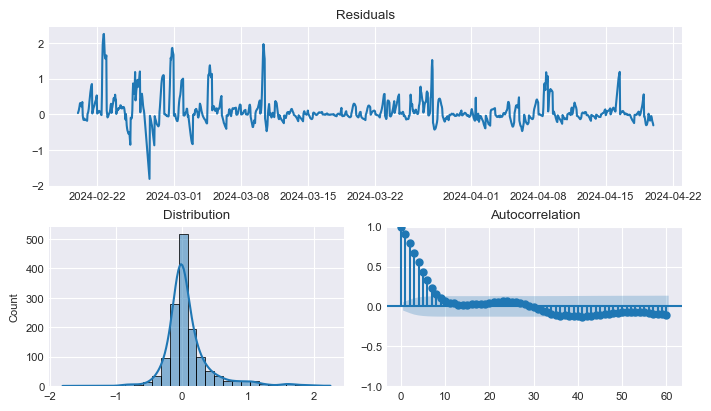

In [63]:
# Out-sample residuals distribution
# ==============================================================================
print(pd.Series(np.where(residuals < 0, 'negative', 'positive')).value_counts())
plt.rcParams.update({'font.size': 8})
_ = plot_residuals(residuals=residuals, figsize=(7, 4))

In [64]:
# Store out-sample residuals in the forecaster
# ==============================================================================
forecaster.set_out_sample_residuals(residuals=residuals)

In [66]:
# Backtesting with prediction intervals in test data using out-sample residuals
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster          = forecaster,
                          y                   = df['wave_height'],
                        #   exog                = data[exog_features],
                          steps               = 12, # changed from 24 to see if intervals are smaller
                          metric              = 'mean_absolute_error',
                          initial_train_size = len(df[:end_val]),
                          refit               = False,
                          interval            = [10, 90], # 80% prediction interval
                          n_boot              = 250,
                          in_sample_residuals = False, # Use out-sample residuals
                          binned_residuals    = False,
                          n_jobs              = 'auto',
                          verbose             = False,
                          show_progress       = True
                      )
predictions.head(5)


  0%|          | 0/120 [00:00<?, ?it/s]

,pred,lower_bound,upper_bound
2024-04-20 00:00:00,1.236425,1.024814,1.796145
2024-04-20 01:00:00,1.212121,0.878158,2.436373
2024-04-20 02:00:00,1.195199,0.772705,2.738838
2024-04-20 03:00:00,1.184654,0.717667,2.954665
2024-04-20 04:00:00,1.171381,0.678376,3.218715


In [67]:
# Plot intervals
# ==============================================================================
plot_predicted_intervals(
    predictions     = predictions,
    y_true          = df_test,
    target_variable = "wave_height",
    # initial_x_zoom  = None,
    title           = "Real value vs predicted in test data",
    xaxis_title     = "Date time",
    yaxis_title     = "users",
)

# Predicted interval coverage (on test data)
# ==============================================================================
coverage = empirical_coverage(
    y = df_test['wave_height'],
    lower_bound = predictions["lower_bound"], 
    upper_bound = predictions["upper_bound"]
)
print(f"Predicted interval coverage: {round(100*coverage, 2)} %")

# Area of the interval
# ==============================================================================
area = (predictions["upper_bound"] - predictions["lower_bound"]).sum()
print(f"Area of the interval: {round(area, 2)}")

Predicted interval coverage: 97.15 %
Area of the interval: 3981.04


### Out sample residuals (conditioned on predicted values)


In [68]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor     = XGBRegressor(random_state=42, **best_params),
                 lags          = 48,
                 binner_kwargs = {'n_bins': 10}   
             )

forecaster.fit(
    y     = df_val['wave_height']
)

In [69]:
from pprint import pprint

# Intervals of the residual bins
# ==============================================================================
pprint(forecaster.binner_intervals)

{0: (0.6044711470603943, 0.721972668170929),
 1: (0.721972668170929, 0.9307864904403687),
 2: (0.9307864904403687, 1.0574825644493102),
 3: (1.0574825644493102, 1.2295759201049805),
 4: (1.2295759201049805, 1.4606908559799194),
 5: (1.4606908559799194, 1.6776943922042848),
 6: (1.6776943922042848, 2.0070210695266724),
 7: (2.0070210695266724, 2.2606672286987304),
 8: (2.2606672286987304, 3.2071647882461556),
 9: (3.2071647882461556, 5.283320426940918)}


In [70]:
# Store out-sample residuals in the forecaster
# ==============================================================================
forecaster.set_out_sample_residuals(residuals=residuals, y_pred=predictions_val['pred'])

In [71]:
# Backtesting with prediction intervals in test data using out-sample residuals
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster          = forecaster,
                          y                   = df['wave_height'],
                          steps               = 12, # changed from 24 to see if intervals are smaller
                          metric              = 'mean_absolute_error',
                          initial_train_size = len(df[:end_val]),
                          refit               = False,
                          interval            = [10, 90], # 80% prediction interval
                          n_boot              = 250,
                          in_sample_residuals = False, # Use out-sample residuals
                          binned_residuals    = True,
                          n_jobs              = 'auto',
                          verbose             = False,
                          show_progress       = True
                      )

                      
predictions.head(3)


  0%|          | 0/120 [00:00<?, ?it/s]

,pred,lower_bound,upper_bound
2024-04-20 00:00:00,1.236425,1.007675,2.585094
2024-04-20 01:00:00,1.212121,0.905996,3.001656
2024-04-20 02:00:00,1.195199,0.832546,3.026705


In [72]:
# Plot intervals
# ==============================================================================
plot_predicted_intervals(
    predictions     = predictions,
    y_true          = df_test,
    target_variable = "wave_height",
    initial_x_zoom  = None,
    title           = "Real value vs predicted in test data",
    xaxis_title     = "Date time",
    yaxis_title     = "users",
)

# Predicted interval coverage (on test data)
# ==============================================================================
coverage = empirical_coverage(
    y = df_test['wave_height'],
    lower_bound = predictions["lower_bound"], 
    upper_bound = predictions["upper_bound"]
)
print(f"Predicted interval coverage: {round(100*coverage, 2)} %")

# Area of the interval
# ==============================================================================
area = (predictions["upper_bound"] - predictions["lower_bound"]).sum()
print(f"Area of the interval: {round(area, 2)}")



Predicted interval coverage: 95.35 %
Area of the interval: 3738.35


### Quantile regression

In [17]:
# Create forecasters: one for each limit of the interval
# ==============================================================================
# The forecasters obtained for alpha=0.1 and alpha=0.9 produce a 80% confidence
# interval (90% - 10% = 80%).

# Forecaster for quantile 10%
forecaster_q10 = ForecasterAutoreg(
                     regressor = LGBMRegressor(
                                     objective    = 'quantile',
                                     metric       = 'quantile',
                                     alpha        = 0.1,
                                     random_state = 42,
                                     verbose      = -1
                                     
                                 ),
                     lags  = 24,
                    #  steps = 24
                 )
# Forecaster for quantile 90%
forecaster_q90 = ForecasterAutoreg(
                     regressor = LGBMRegressor(
                                     objective    = 'quantile',
                                     metric       = 'quantile',
                                     alpha        = 0.9,
                                     random_state = 42,
                                     verbose      = -1
                                     
                                 ),
                     lags  = 24,
                    #  steps = 24
                 )

In [18]:
# Loss function for each quantile (pinball_loss)
# ==============================================================================
def mean_pinball_loss_q10(y_true, y_pred):
    """
    Pinball loss for quantile 10.
    """
    return mean_pinball_loss(y_true, y_pred, alpha=0.1)


def mean_pinball_loss_q90(y_true, y_pred):
    """
    Pinball loss for quantile 90.
    """
    return mean_pinball_loss(y_true, y_pred, alpha=0.9)

In [19]:
# Bayesian search of hyper-parameters and lags for each quantile forecaster
# ==============================================================================
def search_space(trial):
    search_space  = {
        'n_estimators'  : trial.suggest_int('n_estimators', 600, 1200, step=50),
        'max_depth'     : trial.suggest_int('max_depth', 3, 12, step=1),
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.5),
        'reg_alpha'     : trial.suggest_float('reg_alpha', 0, 1, step=0.1),
        'reg_lambda'    : trial.suggest_float('reg_lambda', 0, 1, step=0.1),
        'lags'          : trial.suggest_categorical('lags', [24, 36, 48])
    }

    return search_space

results_grid_q10 = bayesian_search_forecaster(
                       forecaster         = forecaster_q10,
                       y                  = df.iloc[:end_val]['wave_height'],
                       steps              = 24,
                       metric             = mean_pinball_loss_q10,
                       search_space       = search_space,
                       initial_train_size = len(df[:end_train]),
                       refit              = False,
                       n_trials           = 40, # Increase for more exhaustive search
                       random_state       = 123,
                       return_best        = True,
                       n_jobs             = 'auto',
                       verbose            = False,
                       show_progress      = True
                   )

results_grid_q90 = bayesian_search_forecaster(
                       forecaster         = forecaster_q90,
                       y                  = df.iloc[:end_val]['wave_height'],
                       steps              = 24,
                       metric             = mean_pinball_loss_q90,
                       search_space       = search_space,
                       initial_train_size = len(df[:end_train]),
                       refit              = False,
                       n_trials           = 40, # Increase for more exhaustive search
                       random_state       = 123,
                       return_best        = True,
                       n_jobs             = 'auto',
                       verbose            = False,
                       show_progress      = True
                   )



  0%|          | 0/40 [00:00<?, ?it/s]